<a href="https://colab.research.google.com/github/mwelland/ENGPYHS_3NM4/blob/main/Boundary_value_problems.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Boundary value problems are ordinary differential equations where information is known on the boundaries of the domain. E.g.:

$$\frac{d^2 f}{dt^x} +\frac{df}{dx} = 1, \quad f(x=0) = 1000,  f(x=1) = 1$$




## The Shooting method

The shooting method solves boundary values problems using the algorithms we developed for initial value problems, including all the consideration we made for adaptive stepping, stiffness, and high order approximation.

The concept is simple:
1. Choose an *initial* boundary
2. Solve as an IVP to find the function value at the other boundary.
3. Check if the other boundary condition is met.
4. Wrap 1-3 in a root finding algorithm to find the solution.

#### Example:

NB: Ballistic targetting was likely one of the the original motivations for these tools!

We are launching a rocket, and need it to be 50m altitude after 5 seconds. Ignoring aerodynamic drag, what should the initial speed be?


Answer:
This is a 1D problem for altitude as a function of time, $y(t)$. Given gravity is $-9.8 m/s^2$ the equation of motion is:

$$ \frac{\partial^2 y}{\partial t^2} = -g, \quad   y(0) = 0, y(5) = 50 $$

Rewrite this using reduction of order:

$$\begin{align}
\frac{\partial y}{\partial t} &= v \\
\frac{\partial v}{\partial t} &= -g \\
\end{align}$$

In [1]:
# prompt: solve the above system with the solve_ivp method

import numpy as np
from scipy.integrate import solve_ivp, solve_bvp
from scipy.optimize import root

def model(t, y):
  y, v = y
  g = -9.8  # Acceleration due to gravity
  dydt = v
  dvdt = g
  return [dydt, dvdt]

# Initial condition for altitude (y)
y0 = 0

# Define the time span
t_span = [0, 5]

# Define the boundary condition for altitude at the end time
y_end = 50

# Implement the shooting method
def shooting_method(v0):
  y_initial = [y0, v0[0]]
  sol = solve_ivp(model, t_span, y_initial, method='RK45')
  return sol.y[0][-1]


# Find the root for the shooting method
result = root(lambda v0: shooting_method(v0) - y_end, 1) # Initial guess for v0
print(result)
v0 = result.x[0]  # The calculated initial velocity

# Solve the IVP with the found initial velocity
y_initial = [y0, v0]
sol = solve_ivp(model, t_span, y_initial, method='RK45')

# Print the solution
print(f"Initial velocity (v0): {v0:.2f} m/s")
print(f"Altitude at t=5s: {sol.y[0][-1]:.2f} m")

 message: The solution converged.
 success: True
  status: 1
     fun: 2.1316282072803006e-14
       x: [ 3.450e+01]
  method: hybr
    nfev: 4
    fjac: [[-1.000e+00]]
       r: [-5.000e+00]
     qtf: [-3.652e-10]
Initial velocity (v0): 34.50 m/s
Altitude at t=5s: 50.00 m


Look at the analytical solution:
$$y(t) = v0 t - (g t^2)/+2$$

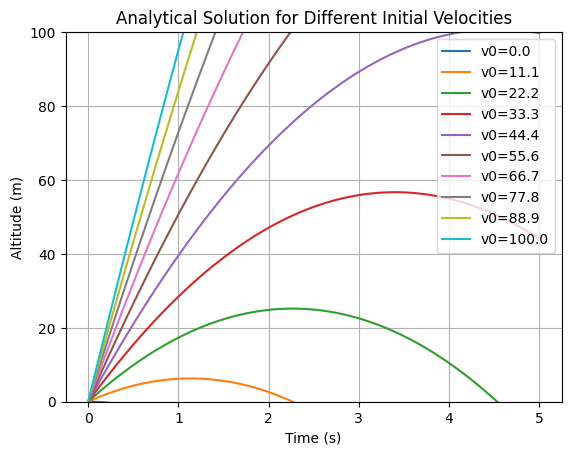

In [2]:
# prompt: plot the analytical asolution with v0 from 0 to 100

import matplotlib.pyplot as plt
import numpy as np

# Analytical solution
g = -9.8
t = np.linspace(0, 5, 100)
v0_values = np.linspace(0, 100, 10)

for v0 in v0_values:
  y_analytical = v0 * t + (g * t**2) / 2
  plt.plot(t, y_analytical, label=f'v0={v0:.1f}')


plt.xlabel('Time (s)')
plt.ylabel('Altitude (m)')
plt.title('Analytical Solution for Different Initial Velocities')
plt.legend()
plt.ylim(0, 100)
plt.grid(True)
plt.show()

#Collocation algorithms

Yet another method involves invoking our interpolator methods to model the solution directly. The process is:

1. Determine a set of (possibly unevenly spaced) points, $x_i$.
2. Define an interpolator function with *unknown* parameters $w_i$.
3. Apply the ODE at each point and find a residual, $R(x_i) = ODE(f(x_i, w_i))
4. Solve (root find or in least squares) for the interpolator parameters.

We can apply a number of interpolators to this scheme, but some common ones include:
- Splines (1D / 2D)
- Radial Basis Functions (ND)
- Neural Networks
- Spectral methods

Spectral methods in this context refers to the use of special basis functions (Sin / cos, Chebychev, Legenre polynomials, etc) with associated optimal collocation points.

**Benefits:**
- Flexibility: Can handle complex geometries and irregular domains.
- High Accuracy: Often provides high accuracy with fewer collocation points, especially with higher-order polynomials.
- Versatility: Suitable for a wide range of problems, including ODEs and PDEs.
- Spectral Methods: Achieve exponential convergence for smooth problems when using spectral collocation (e.g., Chebyshev or Legendre polynomials).

**Drawbacks:**
- Complexity: More complex to implement compared to FDM, especially for higher-order methods.
- Computational Cost: Can be computationally expensive due to the need to solve large systems of equations.
- Stability: Requires careful selection of collocation points to ensure stability and convergence.

## Splines

$$ \frac{\partial^2 y}{\partial t^2} = -g, \quad   y(0) = 0, y(5) = 50 $$

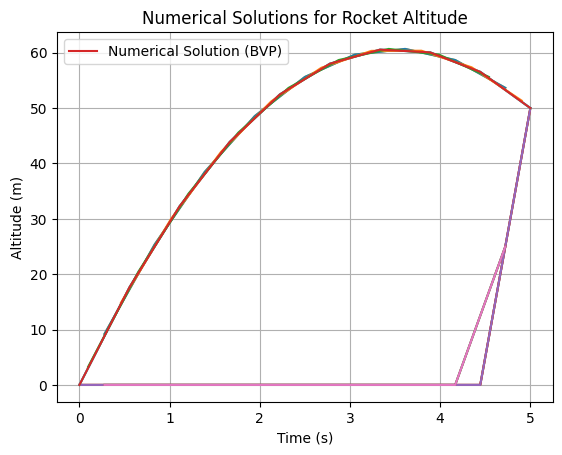

In [4]:
def fun(x, y):
  plt.plot(x,y[0])
  return np.vstack((y[1], -9.8*np.ones_like(y[1])))

def bc(ya, yb):
  return np.array([ya[0], yb[0] - 50])

x = np.linspace(0, 5, 10)
y = np.zeros((2, x.size))
y[0, 0] = 0
y[0, -1] = 50
sol = solve_bvp(fun, bc, x, y)

# Plot the solution from solve_bvp
plt.plot(sol.x, sol.y[0], label='Numerical Solution (BVP)')
plt.xlabel('Time (s)')
plt.ylabel('Altitude (m)')
plt.title('Numerical Solutions for Rocket Altitude')
plt.legend()
plt.grid(True)
plt.show()
